In [1]:

import sys
sys.path.append("../")
from preprocessing.create_train_test_dicts import build_splits

ds = build_splits()
train_split = ds['train_numeric']
val_split = ds['val_numeric']
test_split = ds['test_numeric']


In [ ]:
from preprocessing.svm_pipeline_libsvm import SVCParamSearch
from sklearn.metrics import accuracy_score, f1_score

metrics = {
    "accuracy": accuracy_score,
    "f1_weighted": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted"),
}

search = SVCParamSearch(
    train_dict=train_split,
    val_dict=val_split,
    pca_dims=[10,20,50,100],
    C_values=[1,5,10],
    gamma_values=["scale", 0.001, 0.01],
)

results = search.run()


Evaluating: PCA=10, kernel=rbf, C=1, gamma=scale
Fitting SVC pipeline:  C=1, gamma=scale, n_components=10
  Train size: 21529
  Feature dim after PCA: 10
  Training SVC...
  SVC training complete.
  [Going SVC] PCA=10, kernel=rbf, C=1, gamma=scale
  Val size: 7180
  Predictions done.
  Results: accuracy=0.3032033426183844, f1_weighted=0.25275763446394506

Evaluating: PCA=10, kernel=rbf, C=1, gamma=0.001
Fitting SVC pipeline:  C=1, gamma=0.001, n_components=10
  Train size: 21529
  Feature dim after PCA: 10
  Training SVC...
  SVC training complete.
  [Going SVC] PCA=10, kernel=rbf, C=1, gamma=0.001
  Val size: 7180
  Predictions done.
  Results: accuracy=0.3076601671309192, f1_weighted=0.267399479167235

Evaluating: PCA=10, kernel=rbf, C=1, gamma=0.01
Fitting SVC pipeline:  C=1, gamma=0.01, n_components=10
  Train size: 21529
  Feature dim after PCA: 10
  Training SVC...
  SVC training complete.
  [Going SVC] PCA=10, kernel=rbf, C=1, gamma=0.01
  Val size: 7180
  Predictions done.
  Re

In [ ]:

import pandas as pd
df = pd.DataFrame(results)
df


,pca_dim,kernel,C,gamma,accuracy,f1_weighted
0,2,rbf,1,scale,0.258635,0.14742


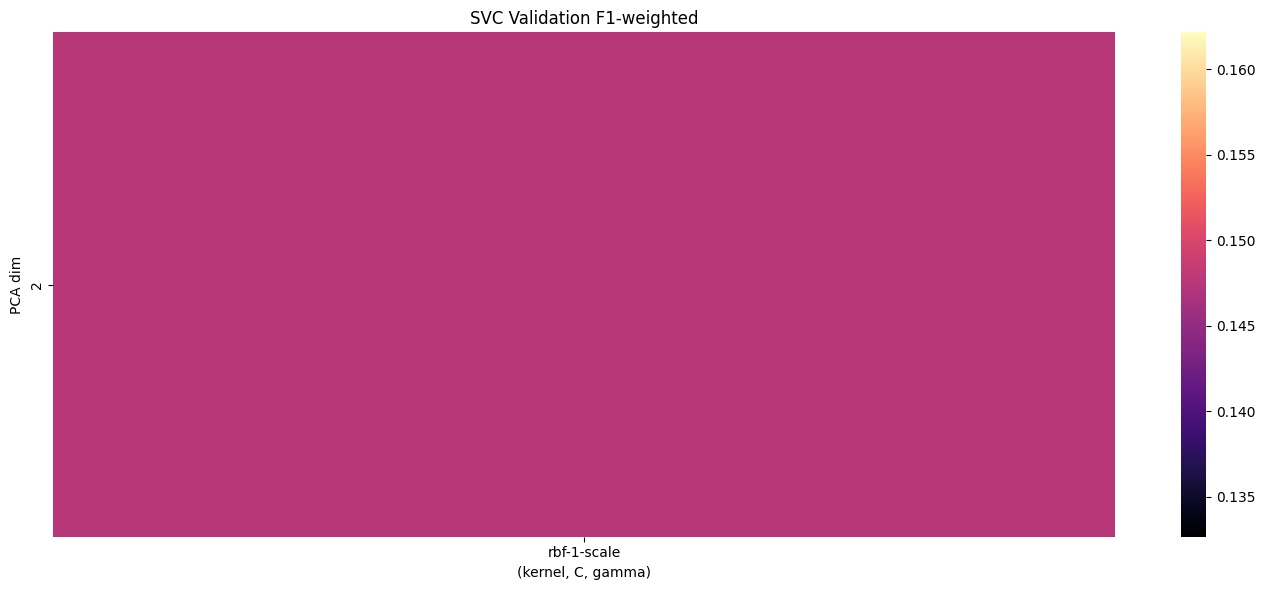

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap for F1 across kernels/params (flattened columns)
pivot_f1 = df.pivot_table(index="pca_dim", columns=["kernel", "C", "gamma"], values="f1_weighted")
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_f1, annot=False, cmap="magma")
plt.title("SVC Validation F1-weighted")
plt.xlabel("(kernel, C, gamma)")
plt.ylabel("PCA dim")
plt.tight_layout()
plt.show()


In [ ]:

# Train best model on train+val, evaluate on test
svc_final, scaler_final, pca_final, X_test, y_test, y_score, class_names = search.train_best_model(
    results,
    test_dict=test_split,
    metric_name="f1_weighted",
)

# ROC & PR curves
SVCParamSearch.plot_roc(y_test, y_score, class_names)
SVCParamSearch.plot_pr(y_test, y_score, class_names)


In [ ]:

# Confusion matrices and metrics
from sklearn.metrics import confusion_matrix
from scripts.metrics_from_cm import metrics_from_confusion_matrix

y_pred = svc_final.predict(X_test)
SVCParamSearch.plot_cm(y_test, y_pred, class_names)
SVCParamSearch.plot_cm(y_test, y_pred, class_names, normalize=True, title="Confusion Matrix (Normalized)")

cm = confusion_matrix(y_test, y_pred, labels=class_names)
metrics_from_cm = metrics_from_confusion_matrix(cm)
metrics_from_cm
